In [1]:
import sys
sys.path.append("..")

In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from time import time

from glob import glob
from pathlib import Path

In [3]:
from src.utils import load_image_targets, show_example_images

## Load and check files

In [4]:
data_root = "../data/"
files = glob("{}/*[x|y].h5".format(data_root))

filepath = defaultdict(dict)
for i in files:
    file_ = Path(i).stem
    condition = re.findall(pattern="train|valid|test", string=file_)[0]
    target_type = re.findall(pattern="_[x|y]", string=file_)[0]
    
    filepath[condition][target_type] = i

In [5]:
# t1 = time()
# train_x, train_y = load_image_targets(
#     filepath["train"]["_x"],
#     filepath["train"]["_y"]
# )
# t2 = time()
# print("Elapse Time: {:.3f}".format(t2-t1))
## ~ 117 secs

# t1 = time()
# valid_x, valid_y = load_image_targets(
#     filepath["valid"]["_x"], 
#     filepath["valid"]["_y"]
# )
# t2 = time()
# print("Elapse Time: {:.3f}".format(t2-t1))
## ~ 14 secs

In [6]:
## ONLY FOR COURSE DEMO
from sklearn.model_selection import train_test_split

t1 = time()
train_x, train_y = load_image_targets(
    filepath["valid"]["_x"],
    filepath["valid"]["_y"]
)
t2 = time()
print("Elapse Time: {:.3f}".format(t2-t1))
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1)

t1 = time()
test_x, test_y = load_image_targets(
    filepath["test"]["_x"], 
    filepath["test"]["_y"]
)
t2 = time()
print("Elapse Time: {:.3f}".format(t2-t1))

Elapse Time: 19.487
Elapse Time: 27.977


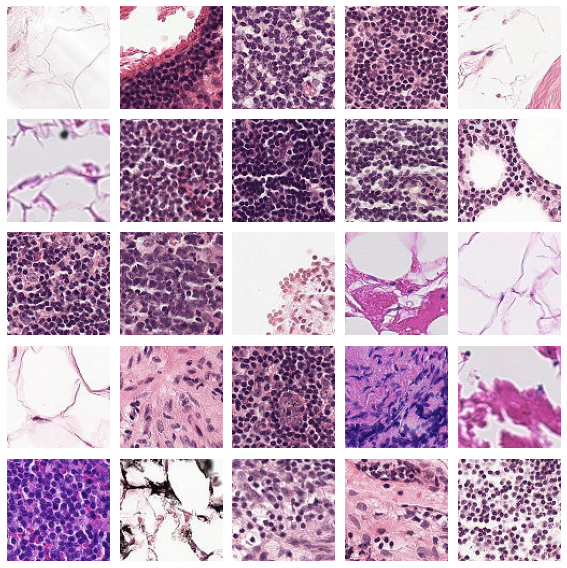

In [7]:
N = 5
index_0 = np.random.choice(np.where(train_y==0)[0], N**2)
examples_0 = np.take(train_x, index_0, axis=0)
show_example_images(examples_0, n_grid_x=N)

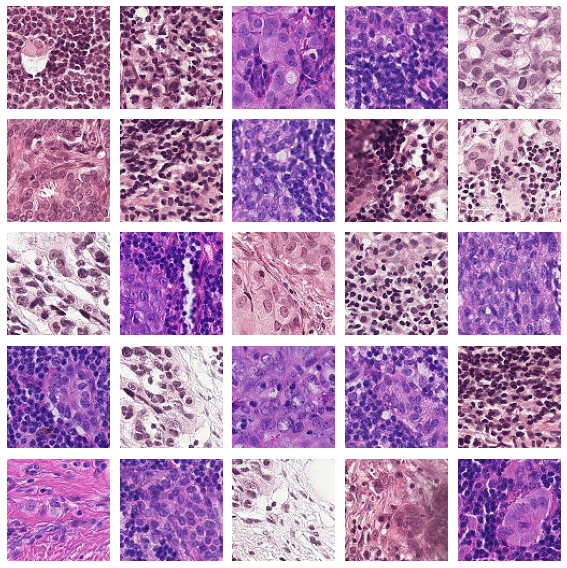

In [8]:
N = 5
index_1 = np.random.choice(np.where(train_y==1)[0], N**2)
examples_1 = np.take(train_x, index_1, axis=0)
show_example_images(examples_1, n_grid_x=N)

## Train classifier - Direct
* Logistic
* XGBoost

In [9]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from src.utils import get_result_metrics

In [10]:
# Vectorize images
train_x_vector = train_x.reshape((len(train_x), -1))
valid_x_vector = valid_x.reshape((len(valid_x), -1))
test_x_vector = test_x.reshape((len(test_x), -1))

print(train_x_vector.shape)

# Simple Normalize
train_x_vector = np.float32(train_x_vector) / 255.
valid_x_vector = np.float32(valid_x_vector) / 255.
test_x_vector = np.float32(test_x_vector) / 255.

(29491, 27648)


In [11]:
model_logistic = LogisticRegression().fit(train_x_vector, train_y)
y_pred = model_logistic.predict_proba(test_x_vector)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


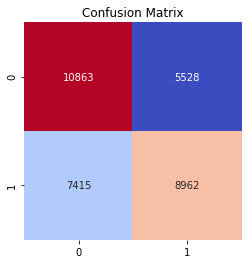

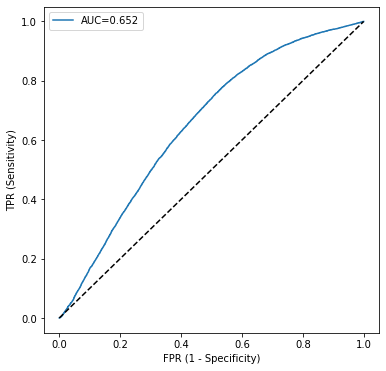

In [12]:
results_logistic = get_result_metrics(y_true=test_y, y_score=y_pred[:,1])

ax = sns.heatmap(
    results_logistic["confusion_matrix"],
    annot=True,
    cmap="coolwarm",
    cbar=False,
    square=True,
    fmt='d'
)
ax.set_title("Confusion Matrix")

plt.figure(figsize=(6,6))
plt.plot(results_logistic["fpr"], results_logistic["tpr"], label="AUC={:.3f}".format(results_logistic["auc"]))
plt.plot([0,1], [0, 1], 'k--')
plt.xlabel("FPR (1 - Specificity)")
plt.ylabel("TPR (Sensitivity)")
plt.legend()
plt.show()

In [13]:
dtrain = xgb.DMatrix(train_x_vector, label=train_y)
dvalid = xgb.DMatrix(valid_x_vector, label=valid_y)
dtest = xgb.DMatrix(test_x_vector, label=test_y)

In [14]:
params_xgb = {
    "max_depth": 6,
    "eta": 0.03,
    "objective": "binary:logistic",
    "nthread": 8,
    "eval_metric": "auc",
    "tree_method": "gpu_hist",
    "gpu_id": 5
}
eval_list = [(dvalid, 'eval'), (dtrain, 'train')]

In [15]:
model_xgb = xgb.train(
    params=params_xgb,
    dtrain=dtrain,
    num_boost_round=100,
    evals=eval_list
)

[0]	eval-auc:0.78548	train-auc:0.80938
[1]	eval-auc:0.82493	train-auc:0.86145
[2]	eval-auc:0.84891	train-auc:0.88205
[3]	eval-auc:0.85586	train-auc:0.88999
[4]	eval-auc:0.86672	train-auc:0.89992
[5]	eval-auc:0.87138	train-auc:0.90628
[6]	eval-auc:0.87842	train-auc:0.91277
[7]	eval-auc:0.87974	train-auc:0.91698
[8]	eval-auc:0.88254	train-auc:0.92073
[9]	eval-auc:0.88480	train-auc:0.92407
[10]	eval-auc:0.88896	train-auc:0.92702
[11]	eval-auc:0.89093	train-auc:0.92880
[12]	eval-auc:0.89385	train-auc:0.93106
[13]	eval-auc:0.89448	train-auc:0.93269
[14]	eval-auc:0.89655	train-auc:0.93518
[15]	eval-auc:0.89740	train-auc:0.93669
[16]	eval-auc:0.89885	train-auc:0.93794
[17]	eval-auc:0.89862	train-auc:0.93915
[18]	eval-auc:0.90046	train-auc:0.94013
[19]	eval-auc:0.90105	train-auc:0.94162
[20]	eval-auc:0.90240	train-auc:0.94317
[21]	eval-auc:0.90345	train-auc:0.94420
[22]	eval-auc:0.90409	train-auc:0.94544
[23]	eval-auc:0.90543	train-auc:0.94597
[24]	eval-auc:0.90541	train-auc:0.94674
[25]	eval-

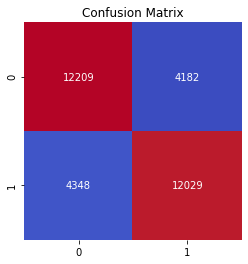

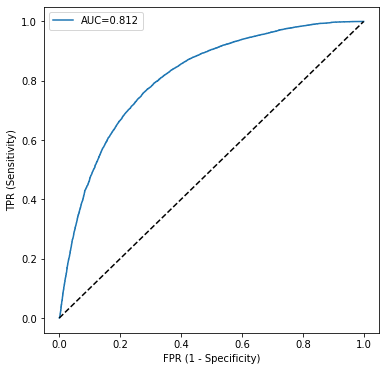

In [16]:
y_pred = model_xgb.predict(dtest)
results_xgb = get_result_metrics(y_true=test_y, y_score=y_pred)

ax = sns.heatmap(
    results_xgb["confusion_matrix"],
    annot=True,
    cmap="coolwarm",
    cbar=False,
    square=True,
    fmt='d'
)
ax.set_title("Confusion Matrix")

plt.figure(figsize=(6,6))
plt.plot(results_xgb["fpr"], results_xgb["tpr"], label="AUC={:.3f}".format(results_xgb["auc"]))
plt.plot([0,1], [0, 1], 'k--')
plt.xlabel("FPR (1 - Specificity)")
plt.ylabel("TPR (Sensitivity)")
plt.legend()
plt.show()

## Train classifer - with feature engineering

In [42]:
import cv2
from skimage.feature import hog, canny

from joblib import Parallel, delayed

def stack_features(image):
    f_hog = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1))
    f_canny = canny(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)).ravel().astype(np.float32)
    
    features = np.concatenate([f_hog, f_canny], axis=0)
    return features

# train_x_features = [stack_features(i) for i in train_x]
train_x_features = Parallel(n_jobs=8)(delayed(stack_features)(img) for img in train_x)
train_x_features = np.array(train_x_features)

valid_x_features = Parallel(n_jobs=8)(delayed(stack_features)(img) for img in valid_x)
valid_x_features = np.array(valid_x_features)

test_x_features = Parallel(n_jobs=8)(delayed(stack_features)(img) for img in test_x)
test_x_features = np.array(test_x_features)

In [49]:
dtrain = xgb.DMatrix(train_x_features, label=train_y)
dvalid = xgb.DMatrix(valid_x_features, label=valid_y)
dtest = xgb.DMatrix(test_x_features, label=test_y)

In [55]:
params_xgb = {
    "max_depth": 6,
    "eta": 0.03,
    "objective": "binary:logistic",
    "nthread": 8,
    "eval_metric": "auc",
    "tree_method": "gpu_hist",
    "gpu_id": 5
}
eval_list = [(dvalid, 'eval'), (dtrain, 'train')]

In [57]:
model_xgb = xgb.train(
    params=params_xgb,
    dtrain=dtrain,
    num_boost_round=500,
    evals=eval_list
)

[0]	eval-auc:0.64262	train-auc:0.65033
[1]	eval-auc:0.65231	train-auc:0.66094
[2]	eval-auc:0.66987	train-auc:0.67679
[3]	eval-auc:0.67727	train-auc:0.68312
[4]	eval-auc:0.67782	train-auc:0.68285
[5]	eval-auc:0.68779	train-auc:0.69046
[6]	eval-auc:0.68768	train-auc:0.69643
[7]	eval-auc:0.68855	train-auc:0.70059
[8]	eval-auc:0.68924	train-auc:0.70290
[9]	eval-auc:0.69714	train-auc:0.70742
[10]	eval-auc:0.69573	train-auc:0.70692
[11]	eval-auc:0.69600	train-auc:0.70725
[12]	eval-auc:0.69788	train-auc:0.71116
[13]	eval-auc:0.70080	train-auc:0.71353
[14]	eval-auc:0.70100	train-auc:0.71356
[15]	eval-auc:0.70049	train-auc:0.71429
[16]	eval-auc:0.70143	train-auc:0.71442
[17]	eval-auc:0.69991	train-auc:0.71595
[18]	eval-auc:0.70062	train-auc:0.71688
[19]	eval-auc:0.70258	train-auc:0.72016
[20]	eval-auc:0.70257	train-auc:0.72043
[21]	eval-auc:0.70127	train-auc:0.72286
[22]	eval-auc:0.70317	train-auc:0.72685
[23]	eval-auc:0.70490	train-auc:0.72769
[24]	eval-auc:0.70560	train-auc:0.72869
[25]	eval-

[203]	eval-auc:0.81033	train-auc:0.96005
[204]	eval-auc:0.81061	train-auc:0.96045
[205]	eval-auc:0.81099	train-auc:0.96121
[206]	eval-auc:0.81153	train-auc:0.96172
[207]	eval-auc:0.81132	train-auc:0.96218
[208]	eval-auc:0.81169	train-auc:0.96267
[209]	eval-auc:0.81209	train-auc:0.96332
[210]	eval-auc:0.81229	train-auc:0.96346
[211]	eval-auc:0.81210	train-auc:0.96399
[212]	eval-auc:0.81244	train-auc:0.96460
[213]	eval-auc:0.81244	train-auc:0.96499
[214]	eval-auc:0.81254	train-auc:0.96528
[215]	eval-auc:0.81281	train-auc:0.96560
[216]	eval-auc:0.81348	train-auc:0.96606
[217]	eval-auc:0.81368	train-auc:0.96672
[218]	eval-auc:0.81394	train-auc:0.96712
[219]	eval-auc:0.81407	train-auc:0.96764
[220]	eval-auc:0.81408	train-auc:0.96797
[221]	eval-auc:0.81432	train-auc:0.96837
[222]	eval-auc:0.81467	train-auc:0.96884
[223]	eval-auc:0.81478	train-auc:0.96920
[224]	eval-auc:0.81481	train-auc:0.96942
[225]	eval-auc:0.81505	train-auc:0.96984
[226]	eval-auc:0.81527	train-auc:0.97028
[227]	eval-auc:0

[403]	eval-auc:0.83987	train-auc:0.99828
[404]	eval-auc:0.83980	train-auc:0.99830
[405]	eval-auc:0.84001	train-auc:0.99833
[406]	eval-auc:0.83996	train-auc:0.99835
[407]	eval-auc:0.83984	train-auc:0.99837
[408]	eval-auc:0.84006	train-auc:0.99840
[409]	eval-auc:0.84003	train-auc:0.99841
[410]	eval-auc:0.84031	train-auc:0.99844
[411]	eval-auc:0.84049	train-auc:0.99847
[412]	eval-auc:0.84067	train-auc:0.99849
[413]	eval-auc:0.84075	train-auc:0.99852
[414]	eval-auc:0.84092	train-auc:0.99854
[415]	eval-auc:0.84092	train-auc:0.99855
[416]	eval-auc:0.84117	train-auc:0.99859
[417]	eval-auc:0.84123	train-auc:0.99861
[418]	eval-auc:0.84126	train-auc:0.99863
[419]	eval-auc:0.84134	train-auc:0.99866
[420]	eval-auc:0.84144	train-auc:0.99868
[421]	eval-auc:0.84137	train-auc:0.99869
[422]	eval-auc:0.84130	train-auc:0.99872
[423]	eval-auc:0.84148	train-auc:0.99875
[424]	eval-auc:0.84152	train-auc:0.99877
[425]	eval-auc:0.84155	train-auc:0.99878
[426]	eval-auc:0.84156	train-auc:0.99878
[427]	eval-auc:0

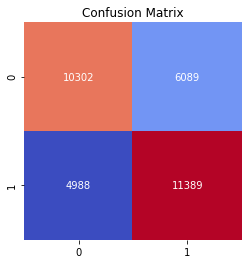

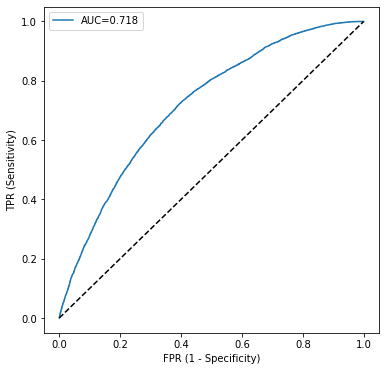

In [58]:
y_pred = model_xgb.predict(dtest)
results_xgb = get_result_metrics(y_true=test_y, y_score=y_pred)

ax = sns.heatmap(
    results_xgb["confusion_matrix"],
    annot=True,
    cmap="coolwarm",
    cbar=False,
    square=True,
    fmt='d'
)
ax.set_title("Confusion Matrix")

plt.figure(figsize=(6,6))
plt.plot(results_xgb["fpr"], results_xgb["tpr"], label="AUC={:.3f}".format(results_xgb["auc"]))
plt.plot([0,1], [0, 1], 'k--')
plt.xlabel("FPR (1 - Specificity)")
plt.ylabel("TPR (Sensitivity)")
plt.legend()
plt.show()

## Unsupervised
* KMeans
* Batch-Kmeans

In [61]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(train_x_vector)

KMeans(n_clusters=2)

In [62]:
y_pred = kmeans.predict(test_x_vector)
k_distance_space = kmeans.transform(test_x_vector)

In [64]:
get_result_metrics(y_true=test_y, y_score=y_pred)

{'fpr': array([0.        , 0.45579891, 1.        ]),
 'tpr': array([0.        , 0.20577639, 1.        ]),
 'auc': 0.37498873984235614,
 'f1_score': 0.24763024469101333,
 'confusion_matrix': array([[ 8920,  7471],
        [13007,  3370]]),
 'recall': 0.20577639372290407,
 'precision': 0.31085693201734155}

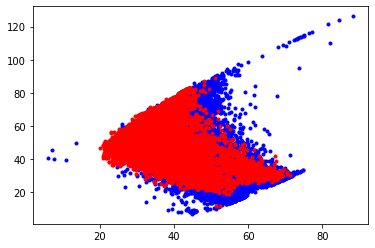

In [72]:
plt.plot(k_distance_space[test_y==0, 0], k_distance_space[test_y==0, 1], 'b.')
plt.plot(k_distance_space[test_y==1, 0], k_distance_space[test_y==1, 1], 'r.')
plt.show()